# 參考 keggle 的空氣汙染預測範例實作
參考來源: https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate

In [118]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
import statsmodels.api as sm  # seasonal trend decomposition
import datetime
from statsmodels.graphics import tsaplots   # autocorrelation
import pymysql
from tensorflow.keras.optimizers import Adam #
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, BatchNormalization, TimeDistributed, Flatten, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras import optimizers
from time import time
from sklearn import preprocessing
from joblib import dump, load
from datetime import datetime, timedelta
from scipy.interpolate import lagrange
from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like
from pandas import Series

%matplotlib inline

In [119]:
# 將資料轉成監督式資料 [B]

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg
# 將資料轉成監督式資料 [E]

In [120]:
# 讀取資料 (csv) [B]
demand_dataframe = pd.read_csv("C:/Users/user/Desktop/ncku_homework/思嘉碩論/資料/Air Pollution Forecasting/LSTM-Multivariate_pollution.csv")

In [121]:
demand_dataframe_org = pd.read_csv("C:/Users/user/Desktop/ncku_homework/思嘉碩論/資料/Air Pollution Forecasting/LSTM-Multivariate_pollution.csv")
demand_dataframe_org = demand_dataframe_org.set_index('date')
# 讀取資料 (csv) [E]

In [122]:
# 參數設定 [B]
train_begin_date = '2010-01-02'
train_end_date = '2013-01-02'
test_begin_date = '2013-01-03'
# test_end_date = '2020-06-07'
# 參數設定 [E]

In [123]:
# Encoding the string based data feature into integers [B]
# 將風向轉成數值
def func(s):
    if s == "SE":
        return 1
    elif s == "NE":
        return 2
    elif s == "NW":
        return 3
    else:
        return 4

demand_dataframe["wind_dir"] = demand_dataframe["wnd_dir"].apply(func)
# Encoding the string based data feature into integers [E]

In [124]:
# 刪除原始風向欄位 [B]
del demand_dataframe["wnd_dir"]
# 刪除原始風向欄位 [E]

In [125]:
df

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,1
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,1
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,1
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,1
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,1
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,3
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,3
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,3
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,246.72,0,0,3


In [164]:
# 資料正規化，使用 MinMaxScaler來做正規化 [B]
# 宣告實例 [B]
dew_zscore = preprocessing.MinMaxScaler()
temperature_zscore = preprocessing.MinMaxScaler()
pres_zscore = preprocessing.MinMaxScaler()
wind_speed_zscore = preprocessing.MinMaxScaler()
snow_zscore = preprocessing.MinMaxScaler()
rain_zscore = preprocessing.MinMaxScaler()
wind_dir_zscore = preprocessing.MinMaxScaler()
pollution_zscore = preprocessing.MinMaxScaler()
# 宣告實例 [E]
# 資料 reshape [B]
dew_reshape_data = demand_dataframe['dew'].values.reshape(-1, 1)
temp_reshape_data = demand_dataframe['temp'].values.reshape(-1, 1)
press_reshape_data = demand_dataframe['press'].values.reshape(-1, 1)
wnd_spd_reshape_data = demand_dataframe['wnd_spd'].values.reshape(-1, 1)
snow_reshape_data = demand_dataframe['snow'].values.reshape(-1, 1)
rain_reshape_data = demand_dataframe['rain'].values.reshape(-1, 1)
wind_dir_reshape_data = demand_dataframe['wind_dir'].values.reshape(-1, 1)
pollution_reshape_data = demand_dataframe['pollution'].values.reshape(-1, 1)
# 資料 reshape [E]
# 部分計算 [B]
dew_zscore.partial_fit(dew_reshape_data)
temperature_zscore.partial_fit(temp_reshape_data)
pres_zscore.partial_fit(press_reshape_data)
wind_speed_zscore.partial_fit(wnd_spd_reshape_data)
snow_zscore.partial_fit(snow_reshape_data)
rain_zscore.partial_fit(rain_reshape_data)
wind_dir_zscore.partial_fit(wind_dir_reshape_data)
pollution_zscore.partial_fit(pollution_reshape_data)
# 部分計算 [E]
# 將部分計算得結果先做正規化 [B]
demand_dataframe['pollution-1'] = pollution_zscore.fit_transform(pollution_reshape_data)
demand_dataframe['dew'] = dew_zscore.fit_transform(dew_reshape_data)
demand_dataframe['temp'] = temperature_zscore.fit_transform(temp_reshape_data)
demand_dataframe['press'] = pres_zscore.fit_transform(press_reshape_data)
demand_dataframe['wnd_spd'] = wind_speed_zscore.fit_transform(wnd_spd_reshape_data)
demand_dataframe['snow'] = snow_zscore.fit_transform(snow_reshape_data)
demand_dataframe['rain'] = rain_zscore.fit_transform(rain_reshape_data)
demand_dataframe['wind_dir'] = wind_dir_zscore.fit_transform(wind_dir_reshape_data)
# 將部分計算得結果先做正規化 [E]
# 資料正規化，使用 MinMaxScaler來做正規化 [E]

In [165]:
demand_dataframe

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir,pollution-1
0,2010-01-02 00:00:00,129.0,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.000000,0.129779
1,2010-01-02 01:00:00,148.0,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,0.148893
2,2010-01-02 02:00:00,159.0,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,0.159960
3,2010-01-02 03:00:00,181.0,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,0.182093
4,2010-01-02 04:00:00,138.0,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,0.138833
...,...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,0.008048
43796,2014-12-31 20:00:00,10.0,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,0.010060
43797,2014-12-31 21:00:00,10.0,0.264706,0.262295,0.781818,0.413996,0.000000,0.0,0.666667,0.010060
43798,2014-12-31 22:00:00,8.0,0.264706,0.245902,0.781818,0.420866,0.000000,0.0,0.666667,0.008048


# 情況 1，未將上一筆 pollution 加入訓練，且預測結果值並未正規化

In [166]:
# 將資料利用 series_to_supervised 的函式轉為監督式資料 [B]
reframed = series_to_supervised(demand_dataframe, 1, 1)
# 將資料利用 series_to_supervised 的函式轉為監督式資料 [E]

In [167]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t)
1,2010-01-02 00:00:00,129.0,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.000000,0.129779,2010-01-02 01:00:00,148.0,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,0.148893
2,2010-01-02 01:00:00,148.0,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,0.148893,2010-01-02 02:00:00,159.0,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,0.159960
3,2010-01-02 02:00:00,159.0,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,0.159960,2010-01-02 03:00:00,181.0,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,0.182093
4,2010-01-02 03:00:00,181.0,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,0.182093,2010-01-02 04:00:00,138.0,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,0.138833
5,2010-01-02 04:00:00,138.0,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,0.138833,2010-01-02 05:00:00,109.0,0.485294,0.213115,0.563636,0.011433,0.111111,0.0,0.000000,0.109658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 18:00:00,10.0,0.264706,0.278689,0.763636,0.385730,0.000000,0.0,0.666667,0.010060,2014-12-31 19:00:00,8.0,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,0.008048
43796,2014-12-31 19:00:00,8.0,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,0.008048,2014-12-31 20:00:00,10.0,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,0.010060
43797,2014-12-31 20:00:00,10.0,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,0.010060,2014-12-31 21:00:00,10.0,0.264706,0.262295,0.781818,0.413996,0.000000,0.0,0.666667,0.010060
43798,2014-12-31 21:00:00,10.0,0.264706,0.262295,0.781818,0.413996,0.000000,0.0,0.666667,0.010060,2014-12-31 22:00:00,8.0,0.264706,0.245902,0.781818,0.420866,0.000000,0.0,0.666667,0.008048


In [168]:
# 移除不需要的欄位 [B]
reframed.drop(reframed.columns[[0, 1, 9, 12, 13, 14, 15, 16, 17, 18, 19]], axis=1, inplace=True)
# 移除不需要的欄位 [E]

In [170]:
reframed.shape

(43799, 9)

In [171]:
# 將 var1 視為index [B]
reframed = reframed.set_index('var1(t)')
# 將 var1 視為index [E]

In [172]:
reframed

,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var2(t)
var1(t),,,,,,,,
2010-01-02 01:00:00,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.000000,148.0
2010-01-02 02:00:00,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,159.0
2010-01-02 03:00:00,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,181.0
2010-01-02 04:00:00,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,138.0
2010-01-02 05:00:00,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,109.0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,0.264706,0.278689,0.763636,0.385730,0.000000,0.0,0.666667,8.0
2014-12-31 20:00:00,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,10.0
2014-12-31 21:00:00,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,10.0


In [173]:
# 將資料分為訓練集與測試集 [B]
train_features = reframed.loc[train_begin_date:train_end_date, 'var3(t-1)':'var9(t-1)'] # 'dew':'wind_dir'
train_labels = reframed.loc[train_begin_date:train_end_date, 'var2(t)'] # 'pollution'


test_features = reframed.loc[test_begin_date:, 'var3(t-1)':'var9(t-1)']
test_labels = reframed.loc[test_begin_date:, 'var2(t)']
# 將資料分為訓練集與測試集 [E]

In [174]:
# 由於 LSTM 僅能接受 3 為陣列，因此需要先將 dataframe 轉為 np 陣列 [B]
train_features = np.array(train_features)
test_features = np.array(test_features)
# 由於 LSTM 僅能接受 3 為陣列，因此需要先將 dataframe 轉為 np 陣列 [E]

In [175]:
# 由於 LSTM 僅能接受 3 為陣列，再將陣列重塑為3為陣列 [B]
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))
# 由於 LSTM 僅能接受 3 為陣列，再將陣列重塑為3為陣列 [E]

In [176]:
# 利用 Vanilla LSTM (many to one) 的模型架構來做訓練 [B]
vanilla_model = Sequential()
vanilla_model.add(LSTM(64, input_shape=(train_features.shape[1],train_features.shape[2]))) #X_train.shape[1],X_train.shape[2]
vanilla_model.add(Dense(1, activation='linear'))
vanilla_model.compile(loss='mae', optimizer='Adam') 
vanilla_model.summary()
# plot_model(model, to_file='Vanilla_LSTM_graph.png')
vanilla_model_result = vanilla_model.fit(train_features, train_labels, epochs = 50, batch_size = 72, validation_split=0.2, verbose=2, shuffle=False) #(50,72)
scores = vanilla_model.evaluate(train_features, train_labels)
# 利用 Vanilla LSTM (many to one) 的模型架構來做訓練 []

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                18432     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
293/293 - 4s - loss: 89.6002 - val_loss: 69.6004
Epoch 2/50
293/293 - 1s - loss: 77.4495 - val_loss: 62.3841
Epoch 3/50
293/293 - 1s - loss: 71.8974 - val_loss: 59.7807
Epoch 4/50
293/293 - 1s - loss: 69.3775 - val_loss: 58.6456
Epoch 5/50
293/293 - 1s - loss: 68.1086 - val_loss: 58.1860
Epoch 6/50
293/293 - 1s - loss: 67.4191 - val_loss: 58.0128
Epoch 7/50
293/293 - 1s - loss: 67.0144 - val_loss: 57.9659
Epoch 8/50
293/293 - 1s - loss: 66.7546 - val_loss: 57.9484
Epoch 9/50
293/293 - 1s - loss: 

In [177]:
# 利用訓練好的模型做預測 [B]
testPredict = vanilla_model.predict(test_features)
# 利用訓練好的模型做預測 [E]

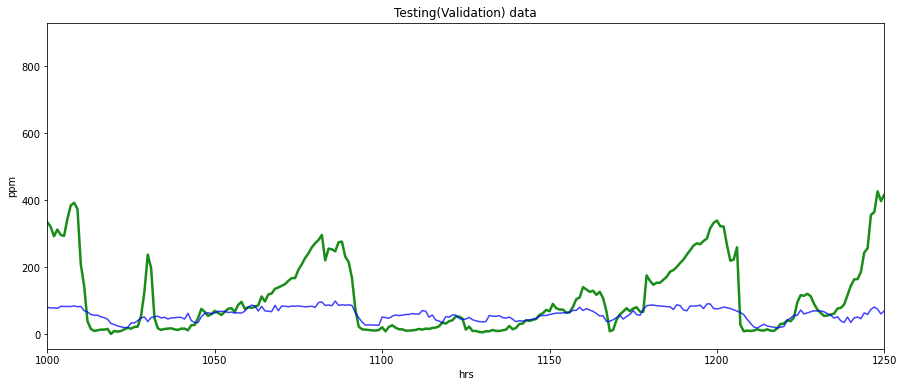

In [178]:
# 將預測結果與實際值做繪圖比較 [B]

from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(Series(test_labels.array), c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()
# 利用訓練好的模型做預測 [E]

-------------------------------

# 情況 2，未將上一筆 pollution 加入訓練，將預測結果值正規化

In [186]:
reframed2 = series_to_supervised(demand_dataframe, 1, 1)

In [187]:
reframed2

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t)
1,2010-01-02 00:00:00,129.0,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.000000,0.129779,2010-01-02 01:00:00,148.0,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,0.148893
2,2010-01-02 01:00:00,148.0,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,0.148893,2010-01-02 02:00:00,159.0,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,0.159960
3,2010-01-02 02:00:00,159.0,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,0.159960,2010-01-02 03:00:00,181.0,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,0.182093
4,2010-01-02 03:00:00,181.0,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,0.182093,2010-01-02 04:00:00,138.0,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,0.138833
5,2010-01-02 04:00:00,138.0,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,0.138833,2010-01-02 05:00:00,109.0,0.485294,0.213115,0.563636,0.011433,0.111111,0.0,0.000000,0.109658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 18:00:00,10.0,0.264706,0.278689,0.763636,0.385730,0.000000,0.0,0.666667,0.010060,2014-12-31 19:00:00,8.0,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,0.008048
43796,2014-12-31 19:00:00,8.0,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,0.008048,2014-12-31 20:00:00,10.0,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,0.010060
43797,2014-12-31 20:00:00,10.0,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,0.010060,2014-12-31 21:00:00,10.0,0.264706,0.262295,0.781818,0.413996,0.000000,0.0,0.666667,0.010060
43798,2014-12-31 21:00:00,10.0,0.264706,0.262295,0.781818,0.413996,0.000000,0.0,0.666667,0.010060,2014-12-31 22:00:00,8.0,0.264706,0.245902,0.781818,0.420866,0.000000,0.0,0.666667,0.008048


In [188]:
reframed2.drop(reframed2.columns[[0, 1, 9, 11, 12, 13, 14, 15, 16, 17, 18]], axis=1, inplace=True)

In [191]:
reframed2 = reframed2.set_index('var1(t)')

In [192]:
reframed2

,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t)
var1(t),,,,,,,,
2010-01-02 01:00:00,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.000000,0.148893
2010-01-02 02:00:00,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,0.159960
2010-01-02 03:00:00,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,0.182093
2010-01-02 04:00:00,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,0.138833
2010-01-02 05:00:00,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,0.109658
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,0.264706,0.278689,0.763636,0.385730,0.000000,0.0,0.666667,0.008048
2014-12-31 20:00:00,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,0.010060
2014-12-31 21:00:00,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,0.010060


In [194]:
train_features2 = reframed2.loc[train_begin_date:train_end_date, 'var3(t-1)':'var9(t-1)'] # 'dew':'wind_dir'
train_labels2 = reframed2.loc[train_begin_date:train_end_date, 'var10(t)'] # 'pollution'


test_features2 = reframed2.loc[test_begin_date:, 'var3(t-1)':'var9(t-1)']
test_labels2 = reframed2.loc[test_begin_date:, 'var10(t)']

In [195]:
# 變成 np 陣列
train_features2 = np.array(train_features2)
test_features2 = np.array(test_features2)

In [196]:
# 變成三維陣列
train_features2 = np.reshape(train_features2, (train_features2.shape[0], 1, train_features2.shape[1]))
test_features2 = np.reshape(test_features2, (test_features2.shape[0], 1, test_features2.shape[1]))

In [197]:
# Vanilla LSTM (many to one) [B]
vanilla_model2 = Sequential()
vanilla_model2.add(LSTM(64, input_shape=(train_features2.shape[1],train_features2.shape[2]))) #X_train.shape[1],X_train.shape[2]
vanilla_model2.add(Dense(1, activation='linear'))
vanilla_model2.compile(loss='mae', optimizer='Adam') 
vanilla_model2.summary()
# plot_model(model, to_file='Vanilla_LSTM_graph.png')
vanilla_model_result2 = vanilla_model2.fit(train_features2, train_labels2, epochs = 50, batch_size = 72, validation_split=0.2, verbose=2, shuffle=False) #(50,72)
scores2 = vanilla_model2.evaluate(train_features2, train_labels2)
# Vanilla LSTM (many to one) [E]

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 64)                18432     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
293/293 - 1s - loss: 0.0621 - val_loss: 0.0616
Epoch 2/50
293/293 - 1s - loss: 0.0586 - val_loss: 0.0661
Epoch 3/50
293/293 - 1s - loss: 0.0585 - val_loss: 0.0665
Epoch 4/50
293/293 - 1s - loss: 0.0583 - val_loss: 0.0655
Epoch 5/50
293/293 - 1s - loss: 0.0577 - val_loss: 0.0645
Epoch 6/50
293/293 - 1s - loss: 0.0574 - val_loss: 0.0640
Epoch 7/50
293/293 - 1s - loss: 0.0570 - val_loss: 0.0637
Epoch 8/50
293/293 - 1s - loss: 0.0566 - val_loss: 0.0634
Epoch 9/50
293/293 - 1s - loss: 0.0564 - val_lo

In [198]:
testPredict2 = vanilla_model2.predict(test_features2)

In [199]:
y_test_true = demand_dataframe_org.loc[test_begin_date:, 'pollution']

In [200]:
poll = pd.Series(demand_dataframe_org['pollution'])

In [201]:
testPredict2 = testPredict2*(poll.max() - poll.min()) + poll.min()

In [202]:
testPredict2

array([[ 9.681899 ],
       [ 9.963449 ],
       [10.402558 ],
       ...,
       [ 5.80413  ],
       [ 6.273019 ],
       [ 6.9575663]], dtype=float32)

In [203]:
y_test_true

date
2013-01-03 00:00:00    23.0
2013-01-03 01:00:00    21.0
2013-01-03 02:00:00    20.0
2013-01-03 03:00:00    18.0
2013-01-03 04:00:00    20.0
                       ... 
2014-12-31 19:00:00     8.0
2014-12-31 20:00:00    10.0
2014-12-31 21:00:00    10.0
2014-12-31 22:00:00     8.0
2014-12-31 23:00:00    12.0
Name: pollution, Length: 17472, dtype: float64

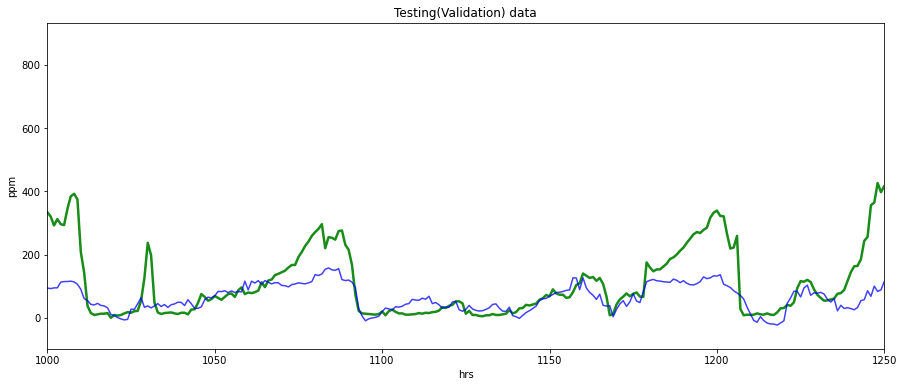

In [204]:
plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(Series(y_test_true.array), c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict2, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

-----------------

# 情況 3，將上一筆 pollution 加入訓練，且將預測結果值正規化

In [205]:
reframed3 = series_to_supervised(demand_dataframe, 1, 1)

In [206]:
reframed3

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t)
1,2010-01-02 00:00:00,129.0,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.000000,0.129779,2010-01-02 01:00:00,148.0,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,0.148893
2,2010-01-02 01:00:00,148.0,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,0.148893,2010-01-02 02:00:00,159.0,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,0.159960
3,2010-01-02 02:00:00,159.0,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,0.159960,2010-01-02 03:00:00,181.0,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,0.182093
4,2010-01-02 03:00:00,181.0,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,0.182093,2010-01-02 04:00:00,138.0,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,0.138833
5,2010-01-02 04:00:00,138.0,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,0.138833,2010-01-02 05:00:00,109.0,0.485294,0.213115,0.563636,0.011433,0.111111,0.0,0.000000,0.109658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 18:00:00,10.0,0.264706,0.278689,0.763636,0.385730,0.000000,0.0,0.666667,0.010060,2014-12-31 19:00:00,8.0,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,0.008048
43796,2014-12-31 19:00:00,8.0,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,0.008048,2014-12-31 20:00:00,10.0,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,0.010060
43797,2014-12-31 20:00:00,10.0,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,0.010060,2014-12-31 21:00:00,10.0,0.264706,0.262295,0.781818,0.413996,0.000000,0.0,0.666667,0.010060
43798,2014-12-31 21:00:00,10.0,0.264706,0.262295,0.781818,0.413996,0.000000,0.0,0.666667,0.010060,2014-12-31 22:00:00,8.0,0.264706,0.245902,0.781818,0.420866,0.000000,0.0,0.666667,0.008048


In [207]:
reframed3.drop(reframed3.columns[[0, 1, 11, 12, 13, 14, 15, 16, 17, 18]], axis=1, inplace=True)

In [209]:
reframed3 = reframed3.set_index('var1(t)')

In [210]:
reframed3

,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var10(t)
var1(t),,,,,,,,,
2010-01-02 01:00:00,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.000000,0.129779,0.148893
2010-01-02 02:00:00,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.000000,0.148893,0.159960
2010-01-02 03:00:00,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.000000,0.159960,0.182093
2010-01-02 04:00:00,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.000000,0.182093,0.138833
2010-01-02 05:00:00,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.000000,0.138833,0.109658
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,0.264706,0.278689,0.763636,0.385730,0.000000,0.0,0.666667,0.010060,0.008048
2014-12-31 20:00:00,0.250000,0.278689,0.781818,0.395659,0.000000,0.0,0.666667,0.008048,0.010060
2014-12-31 21:00:00,0.264706,0.262295,0.781818,0.405588,0.000000,0.0,0.666667,0.010060,0.010060


In [212]:
train_features3 = reframed3.loc[train_begin_date:train_end_date, 'var3(t-1)':'var10(t-1)'] # 'dew':'wind_dir'
train_labels3 = reframed3.loc[train_begin_date:train_end_date, 'var10(t)'] # 'pollution'

test_features3 = reframed3.loc[test_begin_date:, 'var3(t-1)':'var10(t-1)']
test_labels3 = reframed3.loc[test_begin_date:, 'var10(t)']

In [213]:
# 變成 np 陣列
train_features3 = np.array(train_features3)
test_features3 = np.array(test_features3)
# 變成三維陣列
train_features3 = np.reshape(train_features3, (train_features3.shape[0], 1, train_features3.shape[1]))
test_features3 = np.reshape(test_features3, (test_features3.shape[0], 1, test_features3.shape[1]))


In [214]:
# Vanilla LSTM (many to one) [B]
vanilla_model3 = Sequential()
vanilla_model3.add(LSTM(64, input_shape=(train_features3.shape[1],train_features3.shape[2]))) #X_train.shape[1],X_train.shape[2]
vanilla_model3.add(Dense(1, activation='linear'))
vanilla_model3.compile(loss='mae', optimizer='Adam') 
vanilla_model3.summary()
# plot_model(model, to_file='Vanilla_LSTM_graph.png')
vanilla_model_result3 = vanilla_model3.fit(train_features3, train_labels3, epochs = 50, batch_size = 72, validation_split=0.2, verbose=2, shuffle=False) #(50,72)
scores2 = vanilla_model3.evaluate(train_features3, train_labels3)
# Vanilla LSTM (many to one) [E]

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                18688     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 18,753
Trainable params: 18,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
293/293 - 1s - loss: 0.0445 - val_loss: 0.0335
Epoch 2/50
293/293 - 1s - loss: 0.0178 - val_loss: 0.0129
Epoch 3/50
293/293 - 1s - loss: 0.0145 - val_loss: 0.0120
Epoch 4/50
293/293 - 1s - loss: 0.0143 - val_loss: 0.0117
Epoch 5/50
293/293 - 1s - loss: 0.0143 - val_loss: 0.0117
Epoch 6/50
293/293 - 1s - loss: 0.0144 - val_loss: 0.0118
Epoch 7/50
293/293 - 1s - loss: 0.0143 - val_loss: 0.0119
Epoch 8/50
293/293 - 1s - loss: 0.0143 - val_loss: 0.0117
Epoch 9/50
293/293 - 1s - loss: 0.0144 - val_lo

In [215]:
testPredict3 = vanilla_model3.predict(test_features3)
y_test_true3 = demand_dataframe_org.loc[test_begin_date:, 'pollution']
poll = pd.Series(demand_dataframe_org['pollution'])
testPredict3 = testPredict3*(poll.max() - poll.min()) + poll.min()

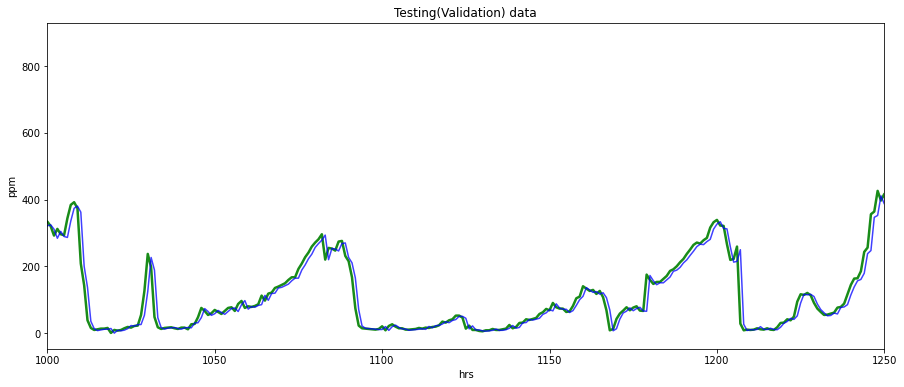

In [216]:
plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(Series(y_test_true3.array), c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict3, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()